In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns


# EDA on Yu-Gi-Oh!
In this notebook we'll use information on the entire collection to try and get some insight on how Yu-Gi-Oh! TCG has evolved throughout the years.

## Loading the data
We start by loading the data. The **cards.csv** file contains the entire catalog of Yu-Gi-Oh! cards.

In [2]:
cards = pd.read_csv("/kaggle/input/yugioh-cards/cards.csv")
print(f"Number of cards in the catalog: {cards.shape[0]}")

Number of cards in the catalog: 12412


The **cardsets.csv** file contains information on Yu-Gi-Oh! sets. In a simplified manner, sets are just a group of cards. You open *booster packs* from a set to get cards from that set's card pool.

In [3]:
sets = pd.read_csv("/kaggle/input/yugioh-cards/cardsets.csv")
print(f"Number of sets: {sets.shape[0]}")
print("Some examples of Yu-Gi-Oh! sets:")
for row in sets.sample(3, random_state=0).itertuples():
    print(f'\t\"{row.set_name}\" released with {row.num_of_cards} cards on {row.tcg_date} on the TCG')

Number of sets: 936
Some examples of Yu-Gi-Oh! sets:
	"Legendary Duelists: Season 1" released with 121 cards on 2020-07-02 on the TCG
	"Duelist Pack: Jesse Anderson" released with 25 cards on 2008-01-26 on the TCG
	"Yu-Gi-Oh! The Dark Side of Dimensions Movie Pack Secret Edition" released with 63 cards on 2020-01-23 on the TCG


The **card_variants.csv** file contains information about the alternative arts of some cards.

There are 161 alternative card arts
Here's an example:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  


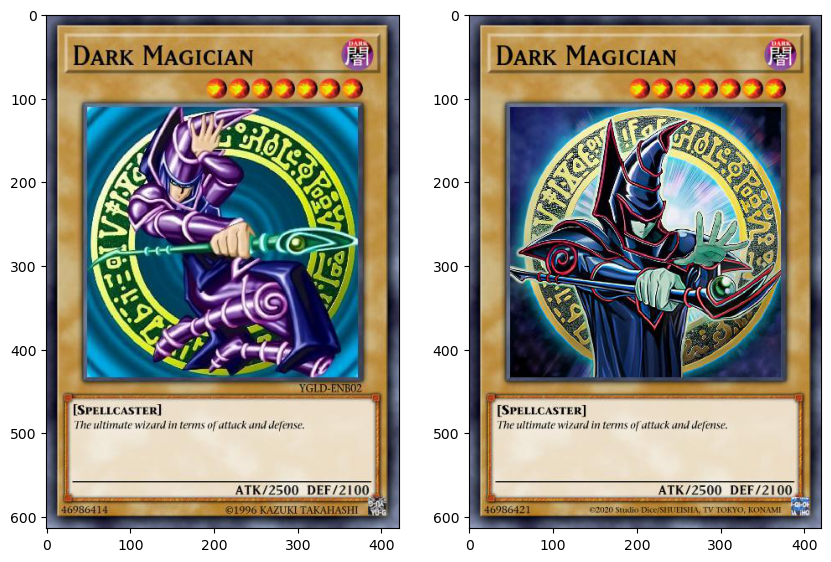

In [4]:
alt_arts = pd.read_csv("/kaggle/input/yugioh-cards/cards_variants.csv")
print(f"There are {alt_arts.shape[0]} alternative card arts")
print("Here's an example:")

fig, ax = plt.subplots(1, 2, figsize=(10, 20))
original, alternative = alt_arts.sample(random_state=12).iloc[0].values
ax[0].imshow(plt.imread(f'https://images.ygoprodeck.com/images/cards/{original}.jpg', format="jpeg"))
ax[1].imshow(plt.imread(f'https://images.ygoprodeck.com/images/cards/{alternative}.jpg', format="jpeg"))

The **cards_cardsets.csv** file contains information that maps cards to the respective sets they were released in. There are more entries in this file than cards in the catalog because a card can be part of multiple sets (reprinted). Yu-Gi-Oh! does not have set rotation, meaning that anything that gets printed and isn't on the banlist can be played, so reprints offer a new supply of older cards.

In [5]:
card_to_set = pd.read_csv("/kaggle/input/yugioh-cards/cards_cardsets.csv")
print(f"Total number of entries: {card_to_set.shape[0]}")

Total number of entries: 33959


## Preprocessing and cleaning
To consider reprints in the analysis, we'll have to merge some of those datasets, as that information is not available in the **cards** dataset.

In [6]:
df = cards.merge(card_to_set, how="right", left_on="id", right_on="card_id", validate="1:m").merge(sets, how="left", left_on="set_id", right_on="id")

In [7]:
pd.set_option("max_columns", 39)

We'll drop features that won't be interesting for the analysis and give more meaningful names to some columns.

In [8]:
df = df.drop(columns=["id_x", "id_y", "image_url_small", "image_url", "num_of_cards", "set_id", "ocg_date", "ban_tcg", "ban_ocg", "ban_goat", "konami_id", "treated_as"])
df = df.rename(columns={"tcg_date_x": "first_print", "tcg_date_y": "release_date", "set_code_y": "set_prefix", "set_code_x": "card_code_in_set"})

# just reordering
df = df[["name", "card_id", "type", "desc", "atk", "def", "level", "race", "attribute", "scale", "archetype", "linkval", "linkmarkers", "staple", "views",
       "viewsweek", "upvotes", "downvotes", "first_print", "release_date", "formats", "set_name", "set_prefix", "card_code_in_set", "set_rarity",
       "set_rarity_code"]]

Converting columns to the appropriate datatype.

In [9]:
df["release_date"] = pd.to_datetime(df["release_date"], format="%Y-%m-%d", errors="coerce")
df["first_print"] = pd.to_datetime(df["first_print"], format="%Y-%m-%d", errors="coerce")

In [10]:
df["staple"] = df["staple"].map({"Yes": 1}).fillna(0).astype(np.int8)

Removing tokens and skill cards.

In [11]:
df = df[~df["type"].isin(["Token", "Skill Card"])]

Removing cards that are yet to be released on the TCG

In [12]:
df = df[df["release_date"] < pd.to_datetime("today")]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33763 entries, 0 to 33958
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   name              33763 non-null  object        
 1   card_id           33763 non-null  int64         
 2   type              33763 non-null  object        
 3   desc              33763 non-null  object        
 4   atk               21561 non-null  float64       
 5   def               20839 non-null  float64       
 6   level             20839 non-null  float64       
 7   race              33763 non-null  object        
 8   attribute         21561 non-null  object        
 9   scale             618 non-null    float64       
 10  archetype         17805 non-null  object        
 11  linkval           722 non-null    float64       
 12  linkmarkers       722 non-null    object        
 13  staple            33763 non-null  int8          
 14  views             3376

We still have a lot of NaN values, but those make sense (e.g. spell cards with an NaN atk value)

## Investigating the data

There are some questions that I'd like to investigate using the data we have.

* When did special summoning start gaining popularity?
* Which attribute/monster type has the most amount of supporting cards?
* What are some of the most loved/hated cards?
* What is the most loved archetype?
* Is the number of new cards (never printed before) increasing or decreasing?
* What rarity do new cards get release as?

### Which attribute/monster type has the most amount of support?

For starters let's get an overall view of the attribute distribution in the dataset (making sure to discard reprints from the analysis).

<AxesSubplot:xlabel='attribute', ylabel='count'>

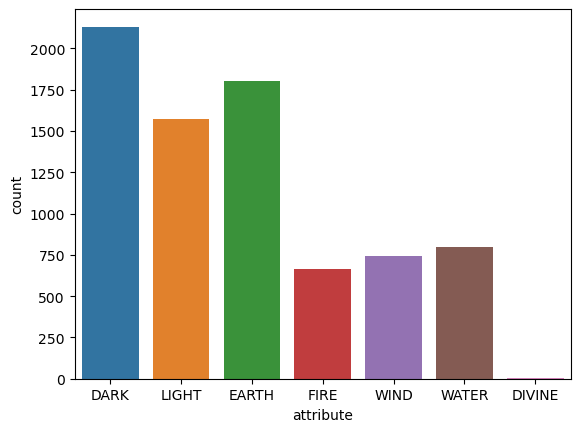

In [14]:
df_unique = df.drop_duplicates("card_id")
sns.countplot(x="attribute", data=df_unique)

The attribute is indicated at the top right on a monster card. The most popular attribute apparently is DARK, with EARTH as a somewhat close second. I honestly expected LIGHT and DARK to be closer together at the top, as they have all the *Chaos* (series of cards that interact with LIGHTs and DARKs) cards and are the attributes of *Dark Magician* and *Blue Eyes White Dragon*.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL f

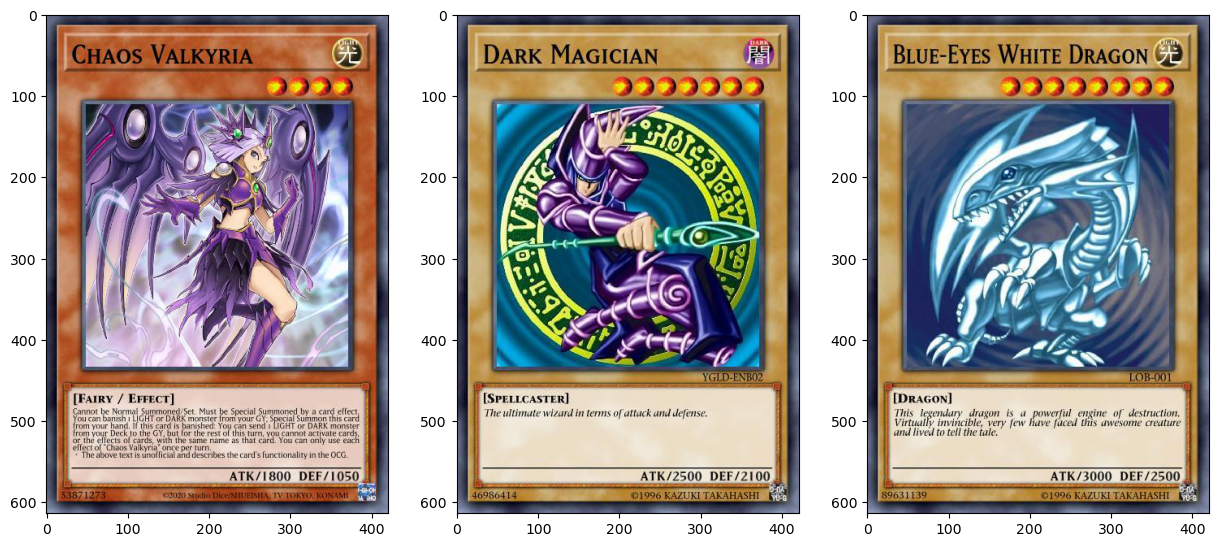

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 30))
ax[0].imshow(plt.imread('https://images.ygoprodeck.com/images/cards/53871273.jpg', format="jpeg"))
ax[1].imshow(plt.imread('https://images.ygoprodeck.com/images/cards/46986414.jpg', format="jpeg"))
ax[2].imshow(plt.imread('https://images.ygoprodeck.com/images/cards/89631139.jpg', format="jpeg"))

In [16]:
attr_by_year = df_unique.groupby(df_unique["first_print"].dt.year)["attribute"].value_counts().to_frame()
attr_by_year = attr_by_year.rename(columns={"attribute": "num_cards"}).reset_index().rename(columns={"first_print": "year"})

In [17]:
total_attr_by_year = df_unique.groupby(df_unique["first_print"].dt.year)["attribute"].count().reset_index().rename(columns={"first_print": "year", "attribute": "num_cards"})
total_attr_by_year["attribute"] = "TOTAL"

#attr_by_year = pd.concat([attr_by_year, total_attr_by_year], axis=0)

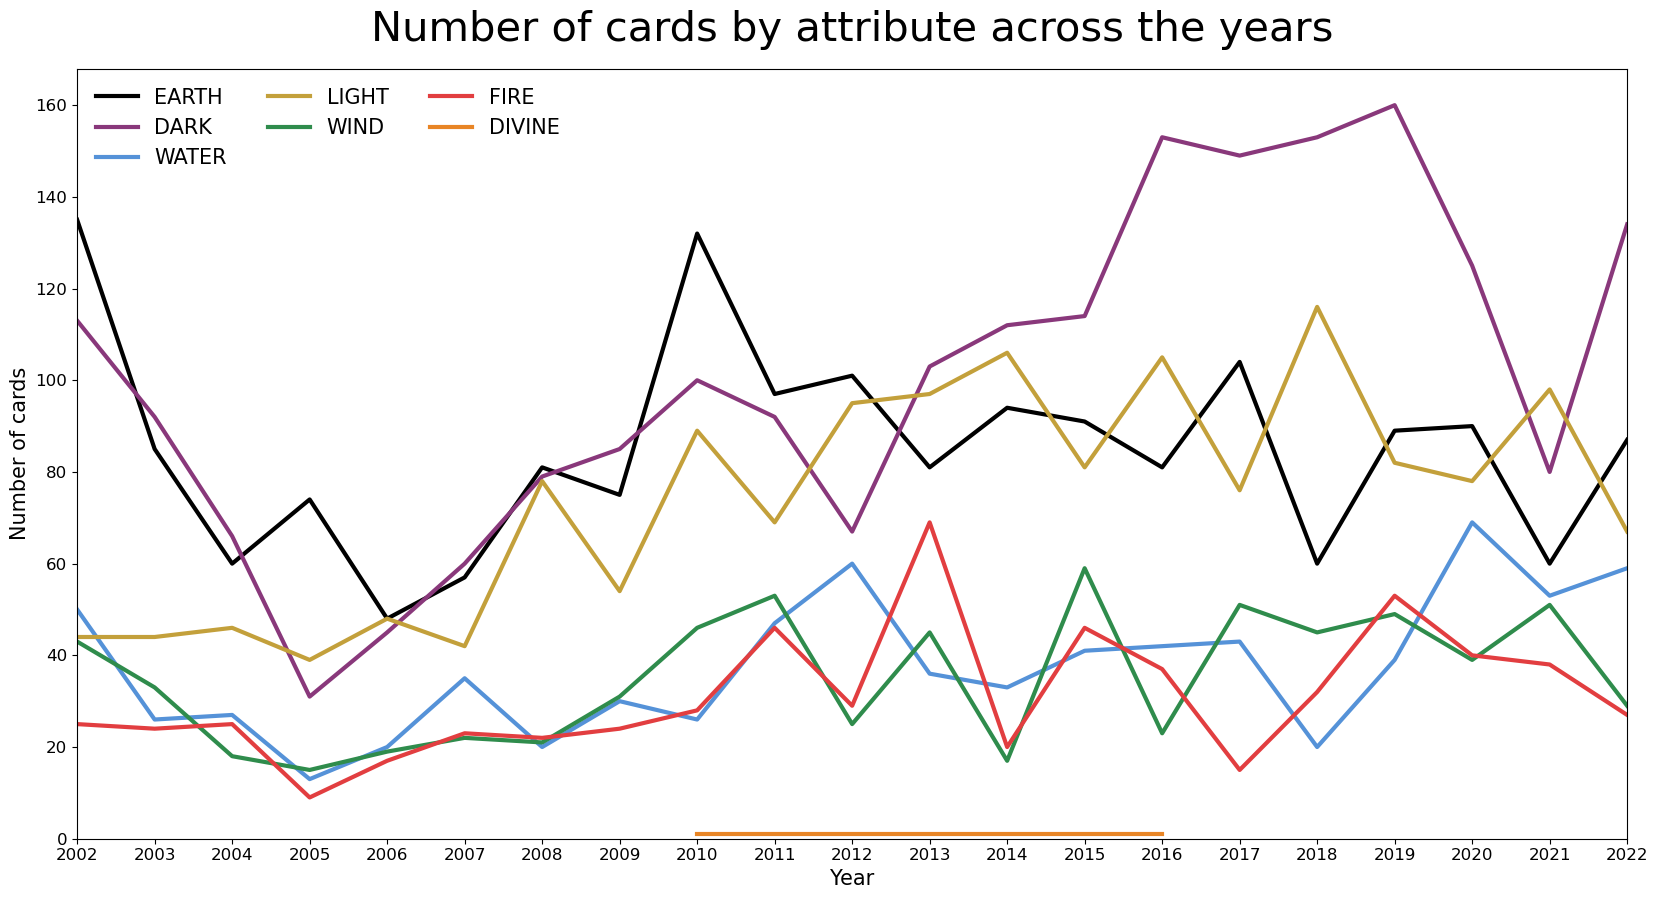

In [18]:
plt.figure(figsize=(20,10))
g = sns.lineplot(data=attr_by_year[attr_by_year["year"].between(2002, 2022)], x="year", y="num_cards", hue="attribute", linewidth=3, palette=["black", "#89387b", "#5592d8", "#c3a03b", "#2f8c4c", "#e23e40", "#e88525"])
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=20))
ax.tick_params(axis="both", which="major", labelsize=12)
ax.set_ylim(ymin=0)
ax.margins(x=0)

ax.set_title("Number of cards by attribute across the years", fontsize=30, pad=20)
ax.set_ylabel("Number of cards", fontsize=15)
ax.set_xlabel("Year", fontsize=15)

plt.legend(loc="upper left", frameon=False, ncol=3, fontsize=15)
for line in ax.get_legend().get_lines():
    line.set_linewidth(3)
 
plt.show()